# Bayesian Multilevel Modeling 

In [1]:
# standard imports 
import pandas as pd 
import numpy as np 

# bayesian modeling 
import pymc as pm
import xarray as xr 

# visualizations
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import arviz as az 
%matplotlib inline
style.use("fivethirtyeight")

# transformers 
from sklearn.preprocessing import OneHotEncoder

In [2]:
# reading in our dataset 

nys_gradrates_df = pd.read_csv("data/2022_nys_gradrates_compiled.csv")

In [3]:
# previewing first five rows of our dataset
nys_gradrates_df.head()

,entity_cd,county,district,nrc_index,school,year,subgroup,grad_rate
0,10100010034,Albany,Albany City Sd,3,Albany High School,2022,Hispanic or Latino,73.7
1,10100010034,Albany,Albany City Sd,3,Albany High School,2022,White,86.9
2,10100010034,Albany,Albany City Sd,3,Albany High School,2022,Multiracial,77.4
3,10100010034,Albany,Albany City Sd,3,Albany High School,2022,English Language Learner,70.4
4,10100010034,Albany,Albany City Sd,3,Albany High School,2022,Economically Disadvantaged,75.5


In [4]:
# transforming subgroups into binary form using pd.getdummies
subgroup_enc = pd.get_dummies(nys_gradrates_df.subgroup,dtype='int64')

# concatenating our two dataframes 
nys_gradrates_df = pd.concat([nys_gradrates_df,subgroup_enc],axis=1)

# dropping the pre-encoded subgroup column
nys_gradrates_df = nys_gradrates_df.drop(columns=["subgroup"])

# shifting column order for readability
nys_gradrates_df = nys_gradrates_df[["entity_cd","county","district","nrc_index","school","year",
                  "American Indian or Alaska Native", "Asian or Native Hawaiian/Other Pacific Islander",
                  "Black or African American","Economically Disadvantaged","English Language Learner",
                  "Hispanic or Latino","Multiracial","Students with Disabilities","White","grad_rate"]]
# standardizing the percentages to be floats
nys_gradrates_df.grad_rate = nys_gradrates_df.grad_rate/100

In [5]:
nys_gradrates_df.head()

,entity_cd,county,district,nrc_index,school,year,American Indian or Alaska Native,Asian or Native Hawaiian/Other Pacific Islander,Black or African American,Economically Disadvantaged,English Language Learner,Hispanic or Latino,Multiracial,Students with Disabilities,White,grad_rate
0,10100010034,Albany,Albany City Sd,3,Albany High School,2022,0,0,0,0,0,1,0,0,0,0.737
1,10100010034,Albany,Albany City Sd,3,Albany High School,2022,0,0,0,0,0,0,0,0,1,0.869
2,10100010034,Albany,Albany City Sd,3,Albany High School,2022,0,0,0,0,0,0,1,0,0,0.774
3,10100010034,Albany,Albany City Sd,3,Albany High School,2022,0,0,0,0,1,0,0,0,0,0.704
4,10100010034,Albany,Albany City Sd,3,Albany High School,2022,0,0,0,1,0,0,0,0,0,0.755


In [6]:
# number of unique districts
len(nys_gradrates_df.district.unique())

660

In [7]:
# number of unique counties 
len(nys_gradrates_df.county.unique())

62

In [8]:
# number of unique schools
len(nys_gradrates_df.school.unique())

1240

<Axes: >

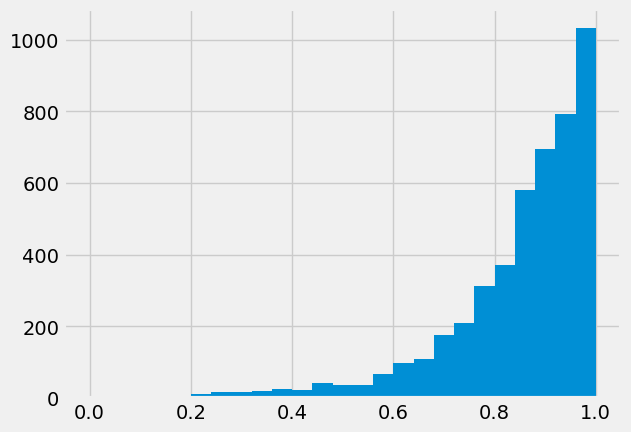

In [9]:
nys_gradrates_df.grad_rate.hist(bins=25)

## Hierarchical Bayesian Modeling

To build up to a hierarchical model, we'll start off simple, trying to predict 

In [10]:
# setting a random seed for reproducibility
r_seed = 205

In [11]:
# creating a lookup dictionary for indexing

nys_counties = nys_gradrates_df.county.unique() # list of all unique counties 
n_counties = len(nys_counties) # 62 unique counties
county_lookup = dict(zip(nys_counties, range(n_counties))) # dictionary with county name and index 

In [12]:
# creating local copies of variables for future models 
county = nys_gradrates_df["county_code"] = nys_gradrates_df.county.replace(county_lookup).values
grad_rate = nys_gradrates_df.grad_rate # predictor var: float64

# index variables for each subgroup 
hisp_latinx = nys_gradrates_df['Hispanic or Latino'].values
ells = nys_gradrates_df['English Language Learner'].values
amer_native = nys_gradrates_df['American Indian or Alaska Native'].values
aapi = nys_gradrates_df['Asian or Native Hawaiian/Other Pacific Islander'].values
aa_blk = nys_gradrates_df['Black or African American'].values
swd = nys_gradrates_df['Students with Disabilities'].values
white = nys_gradrates_df['White'].values
multiracial = nys_gradrates_df['Multiracial'].values
econ_disadv = nys_gradrates_df['Economically Disadvantaged'].values

### Pooled Model 

For simplicity's sake, we'll build a simple model 

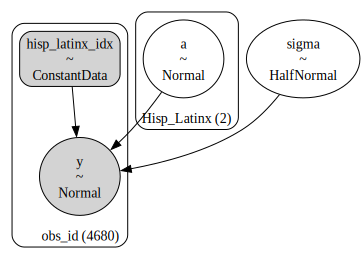

In [13]:
# setting up the dimensions of our model
coords = {"Hisp_Latinx":[0,1], "obs_id": np.arange(hisp_latinx.size)}

# building up our model 
with pm.Model(coords=coords) as pooled_model: 
    hisp_latinx_idx = pm.ConstantData("hisp_latinx_idx", hisp_latinx, dims = "obs_id")
    # setting up priors 
    a = pm.Normal("a", 0.8, sigma=0.05, dims="Hisp_Latinx")
    
    theta = a[hisp_latinx_idx]
    sigma = pm.HalfNormal("sigma",1.0)
    
    y = pm.Normal("y", theta, sigma=sigma, observed=grad_rate, dims="obs_id")
pm.model_to_graphviz(pooled_model)

Sampling: [a, sigma, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


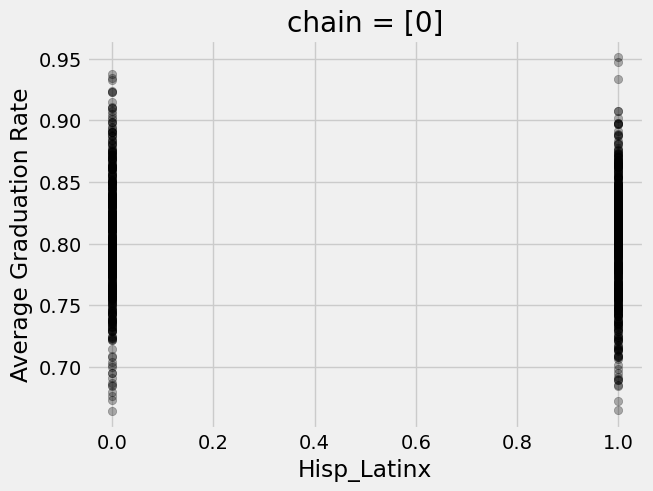

In [14]:
with pooled_model:
    prior_checks = pm.sample_prior_predictive(random_seed=r_seed)
    idata_prior = prior_checks.extend(pm.sample())
    
_, ax = plt.subplots()
prior_checks.prior.plot.scatter(x='Hisp_Latinx',y="a",color="k",alpha=0.3,ax=ax)
ax.set_ylabel("Average Graduation Rate");

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


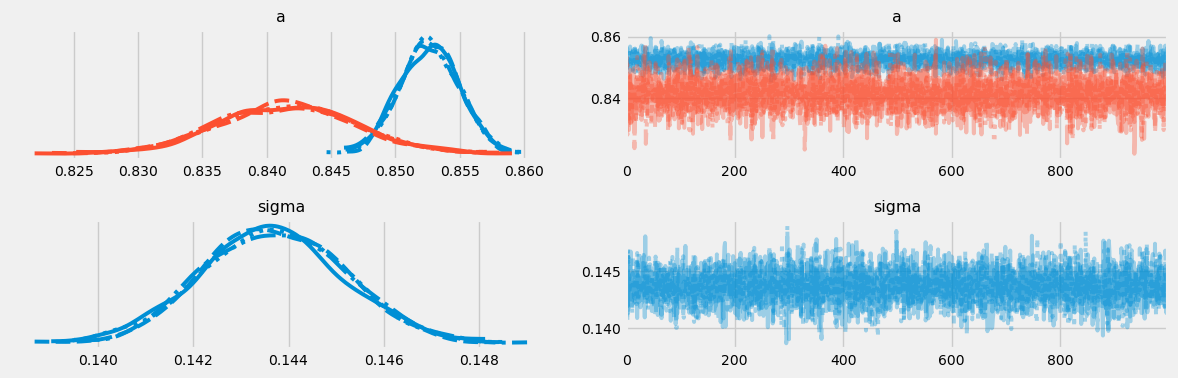

In [15]:
with pooled_model:
    pooled_trace = pm.sample(random_seed=r_seed)
    pooled_idata = az.plot_trace(pooled_trace)
az.summary(pooled_trace)
plt.tight_layout()

In [39]:
az.summary(pooled_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.85,0.00,0.85,0.86,0.0,0.0,6019.76,2852.91,1.0
a[1],0.84,0.01,0.83,0.85,0.0,0.0,5712.26,2942.53,1.0
sigma,0.14,0.00,0.14,0.15,0.0,0.0,6128.90,3369.85,1.0


### Unpooled Model 

The unpooled model ...

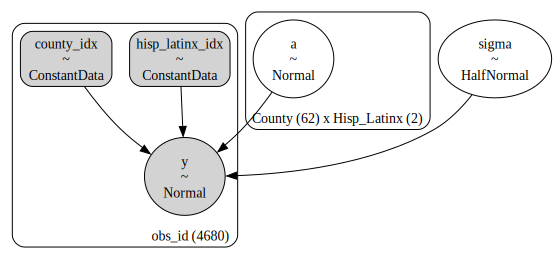

In [16]:
# updating the dimensions of our model
coords["County"] = nys_counties

# building up our unpooled model 
with pm.Model(coords=coords) as unpooled_model:
    hisp_latinx_idx = pm.ConstantData("hisp_latinx_idx", hisp_latinx, dims = "obs_id")
    county_idx = pm.ConstantData("county_idx", county, dims="obs_id")
    # setting up our priors 
    a = pm.Normal("a", 0.8, sigma=0.05, dims=("County","Hisp_Latinx"))
    
    theta = a[county_idx,hisp_latinx_idx]
    sigma = pm.HalfNormal("sigma",1.0)
    
    y = pm.Normal("y",theta, sigma=sigma, observed=grad_rate,dims="obs_id")
pm.model_to_graphviz(unpooled_model)

In [17]:
with unpooled_model:
    unpooled_idata = pm.sample(return_inferencedata=True, random_seed=r_seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


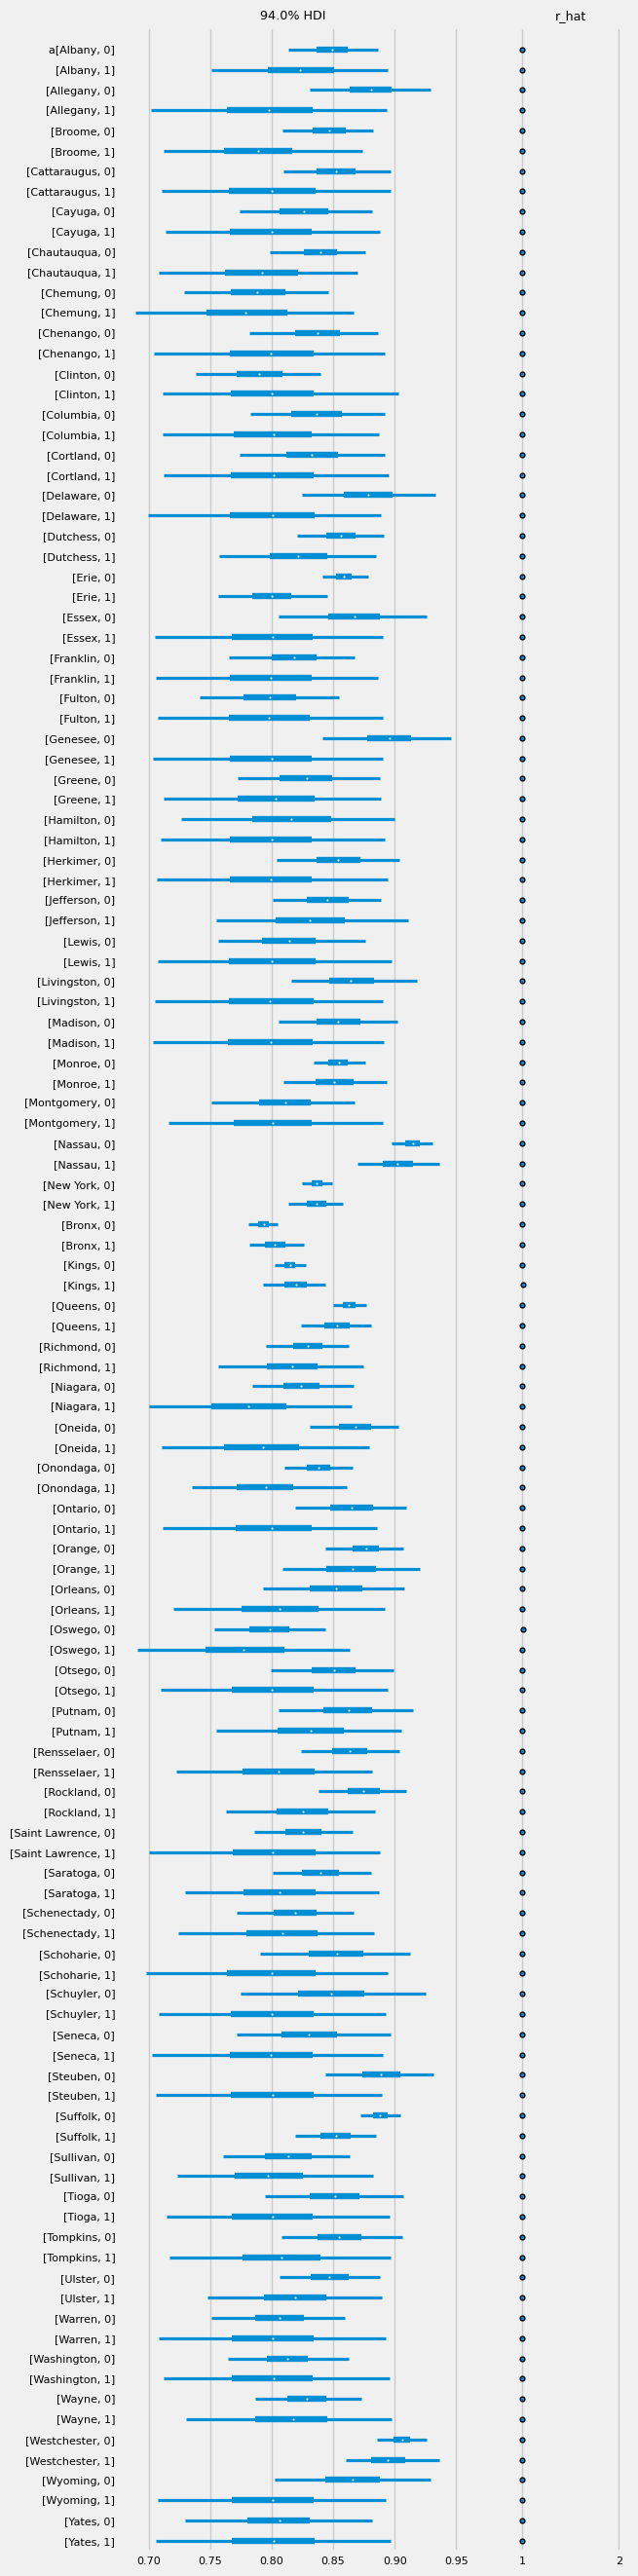

In [18]:
# expected values for effect of being Hispanic/Latinx subgroup in each county 
az.plot_forest(unpooled_idata, var_names="a", figsize=(6, 32), r_hat=True, combined=True, textsize=8);

In [19]:
#unpooled_means = unpooled_idata.posterior.mean(dim=("chain", "draw"))
#unpooled_hdi = az.hdi(unpooled_idata)

## Hierarchical Modeling

### Varying Intercepts Model 

The `varying_intercept` model ...

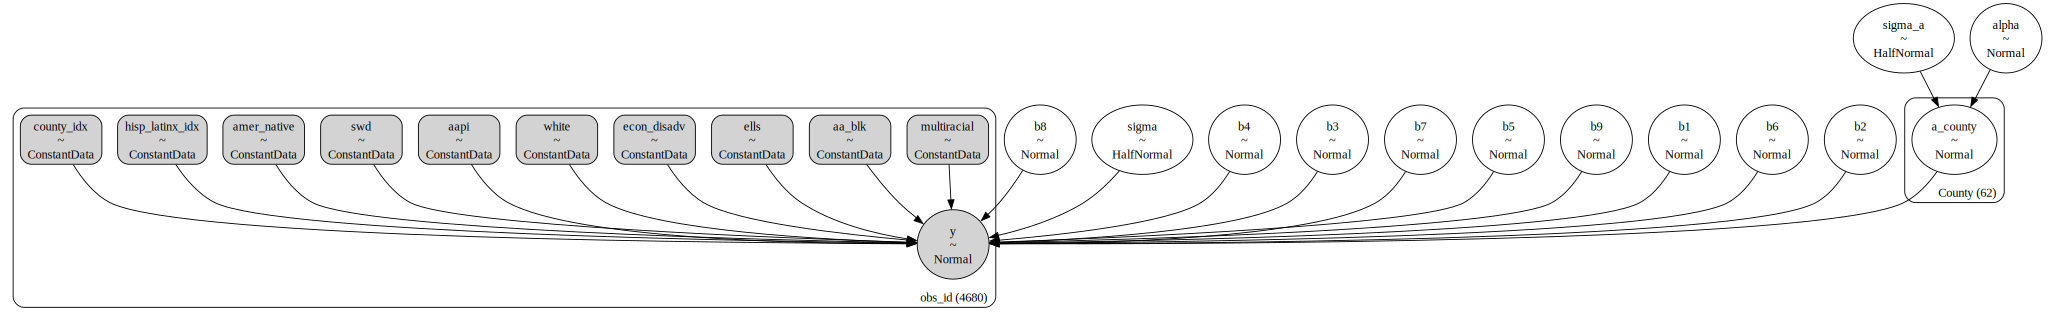

In [20]:
with pm.Model(coords=coords) as varying_intercept:
    # adding our county level index variables
    county_idx = pm.ConstantData("county_idx", county,dims="obs_id") 
    
    # adding subgroup index variables 
    hisp_latinx_idx = pm.ConstantData("hisp_latinx_idx",hisp_latinx,dims="obs_id")
    ells_idx = pm.ConstantData("ells",ells, dims="obs_id")
    amer_native_idx = pm.ConstantData("amer_native",amer_native,dims="obs_id")
    aapi_idx = pm.ConstantData("aapi", aapi, dims="obs_id")
    aablk_idx = pm.ConstantData("aa_blk", aa_blk, dims="obs_id") 
    swd_idx = pm.ConstantData("swd",swd, dims="obs_id")
    white_idx = pm.ConstantData("white", white, dims="obs_id")
    multiracial_idx = pm.ConstantData("multiracial", multiracial, dims="obs_id")
    econ_disadv_idx = pm.ConstantData("econ_disadv", econ_disadv, dims="obs_id")
    
    # hyperpriors 
    alpha = pm.Normal("alpha",mu=0.80, sigma=0.05) 
    sigma_a = pm.HalfNormal("sigma_a",1.0)
    
    # varying intercepts 
    a_county = pm.Normal("a_county",mu=alpha, sigma=sigma_a, dims="County")
    
    # common slopes for each explanatory variable
    b1 = pm.Normal("b1",mu=0.0, sigma=5.0)
    b2 = pm.Normal("b2",mu=0.0, sigma=5.0)
    b3 = pm.Normal("b3",mu=0.0, sigma=5.0)
    b4 = pm.Normal("b4",mu=0.0, sigma=5.0)
    b5 = pm.Normal("b5",mu=0.0, sigma=5.0)
    b6 = pm.Normal("b6",mu=0.0, sigma=5.0)
    b7 = pm.Normal("b7",mu=0.0, sigma=5.0)
    b8 = pm.Normal("b8",mu=0.0, sigma=5.0)
    b9 = pm.Normal("b9",mu=0.0, sigma=5.0)
    
    # expected values per county: 
    theta = a_county[county_idx] + (b1 * hisp_latinx_idx) + (b2 * ells_idx) + \
        (b3 * amer_native_idx) + (b4 * aapi_idx) +(b5 * aablk_idx) + (b6 * swd_idx) + \
        (b7 * white_idx) + (b8 * multiracial_idx) + (b9 * econ_disadv_idx)

    # model error 
    sigma = pm.HalfNormal("sigma", 1.0)

    # likelihood function
    y = pm.Normal("y",theta, sigma=sigma, observed=grad_rate,dims="obs_id")
    
pm.model_to_graphviz(varying_intercept)

In [21]:
y

y ~ Normal(f(b9, b8, b7, b6, b5, b4, b3, b2, a_county, b1), sigma)

In [22]:
alpha

alpha ~ Normal(0.8, 0.05)

In [23]:
b1

b1 ~ Normal(0, 5)

In [24]:
# run_time = ~ 7 minutes
with varying_intercept:
    varying_intercept_idata = pm.sample(
        draws=5000,tune=2000, init="adapt_diag", random_seed=r_seed, target_accept=.99,cores=3,chains=5,
        return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (5 chains in 3 jobs)
NUTS: [alpha, sigma_a, a_county, b1, b2, b3, b4, b5, b6, b7, b8, b9, sigma]


Sampling 5 chains for 2_000 tune and 5_000 draw iterations (10_000 + 25_000 draws total) took 895 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


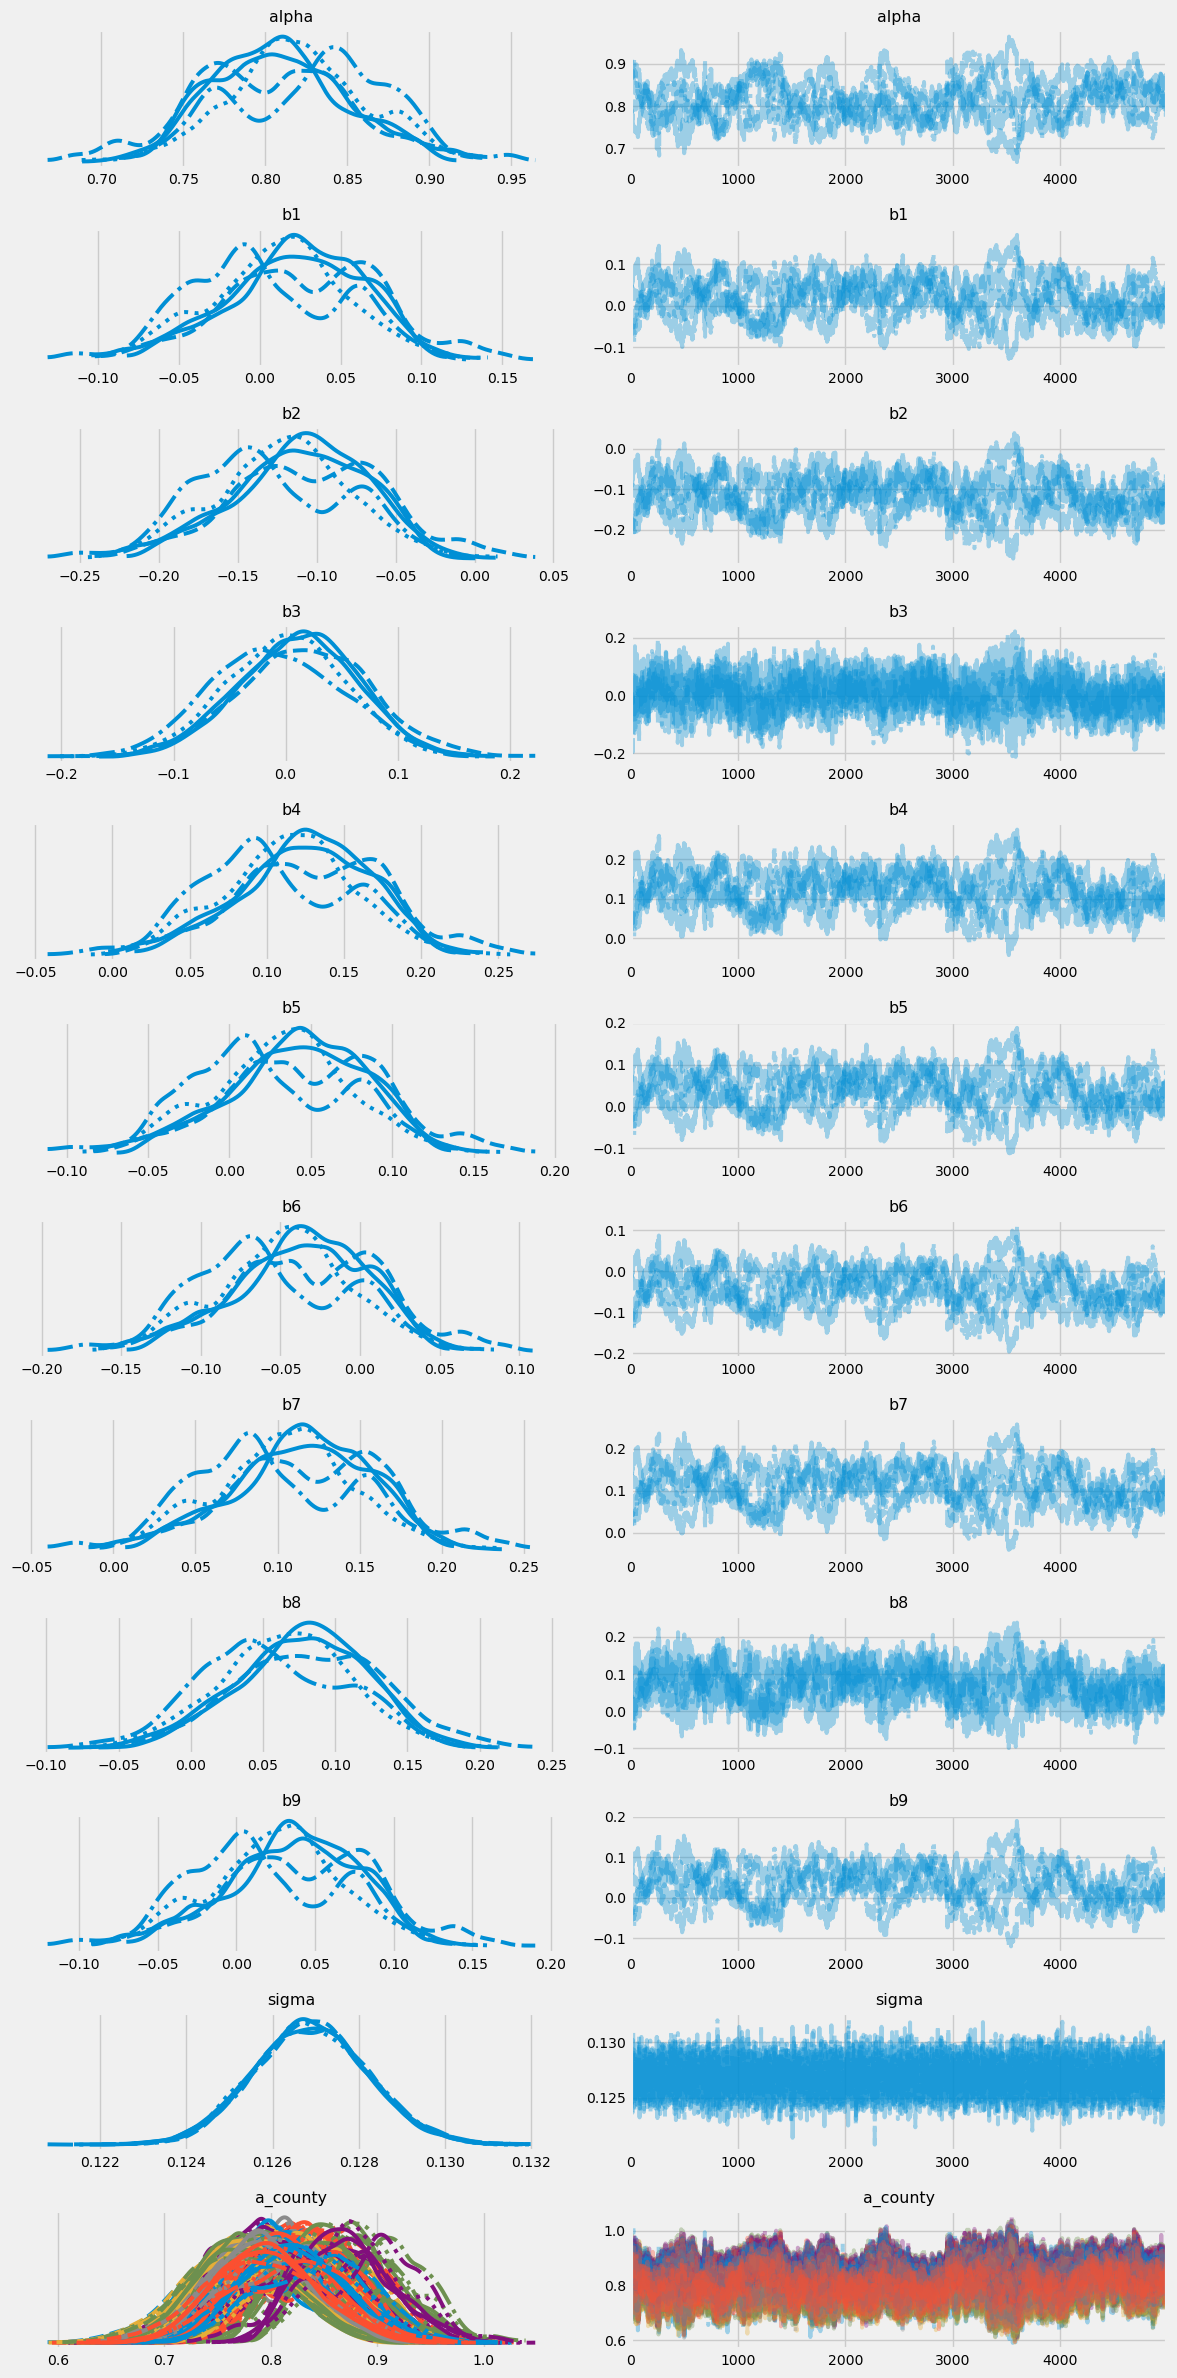

In [25]:
az.plot_trace(varying_intercept_idata,var_names=["alpha","b1","b2","b3","b4","b5","b6","b7","b8","b9","sigma","a_county"])
plt.tight_layout()

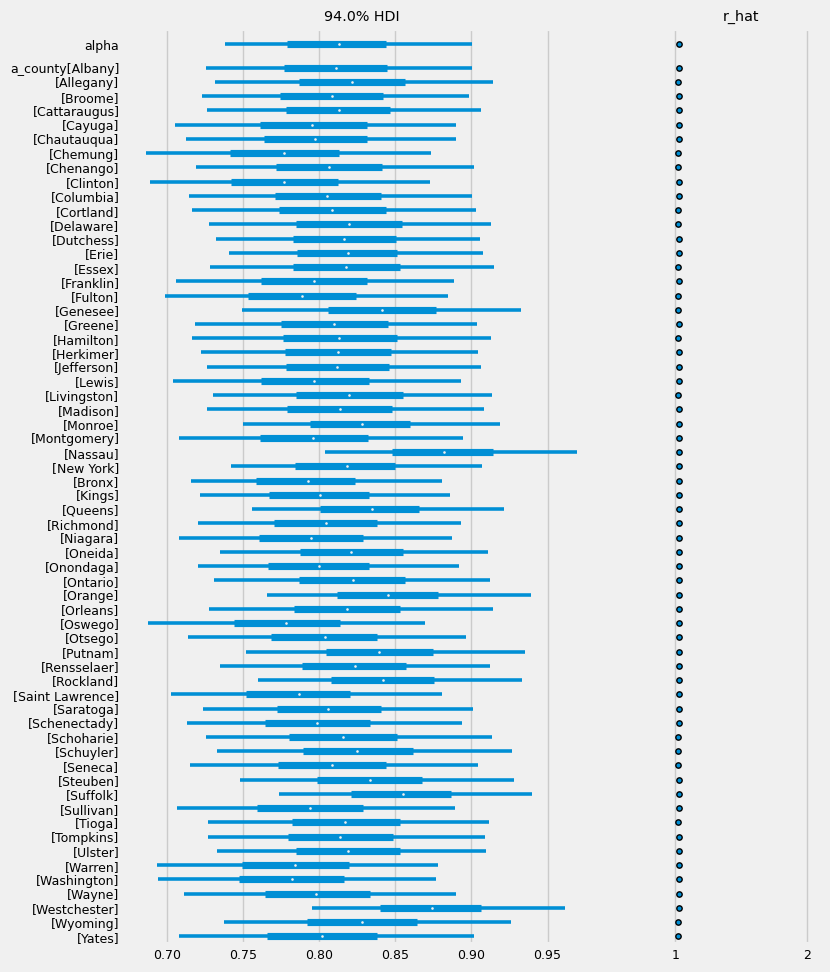

In [26]:
az.plot_forest(
    varying_intercept_idata, var_names=["alpha", "a_county"], r_hat=True, combined=True, textsize=9);

In [34]:
# summary of intercepts 
az.summary(varying_intercept_idata, var_names=["a_county"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_county[Albany],0.812,0.048,0.726,0.900,0.005,0.003,111.0,292.0,1.04
a_county[Allegany],0.822,0.050,0.732,0.914,0.005,0.003,123.0,347.0,1.03
a_county[Broome],0.809,0.048,0.723,0.899,0.004,0.003,117.0,314.0,1.03
a_county[Cattaraugus],0.814,0.049,0.727,0.906,0.004,0.003,124.0,333.0,1.03
a_county[Cayuga],0.797,0.050,0.705,0.890,0.005,0.003,124.0,351.0,1.03
...,...,...,...,...,...,...,...,...,...
a_county[Washington],0.783,0.050,0.694,0.877,0.004,0.003,125.0,372.0,1.03
a_county[Wayne],0.800,0.049,0.711,0.890,0.004,0.003,119.0,331.0,1.03
a_county[Westchester],0.875,0.046,0.795,0.962,0.005,0.003,107.0,257.0,1.04
a_county[Wyoming],0.829,0.051,0.738,0.926,0.004,0.003,134.0,402.0,1.03


In [27]:
# summary of coefficients 
az.summary(varying_intercept_idata, var_names=["alpha","b1","b2","b3","b4","b5","b6","b7","b8","b9"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.81,0.05,0.74,0.90,0.0,0.0,104.40,248.07,1.04
b1,0.02,0.05,-0.07,0.09,0.0,0.0,105.46,248.74,1.04
b2,-0.11,0.05,-0.20,-0.03,0.0,0.0,106.78,266.16,1.04
b3,0.01,0.06,-0.10,0.11,0.0,0.0,161.64,536.18,1.03
b4,0.12,0.05,0.03,0.20,0.0,0.0,106.16,260.41,1.04
b5,0.04,0.05,-0.05,0.12,0.0,0.0,105.71,248.32,1.04
b6,-0.04,0.05,-0.13,0.04,0.0,0.0,105.39,248.92,1.04
b7,0.11,0.05,0.02,0.19,0.0,0.0,105.32,248.66,1.04
b8,0.07,0.05,-0.02,0.16,0.0,0.0,118.54,326.11,1.03
b9,0.03,0.05,-0.06,0.11,0.0,0.0,105.08,247.04,1.04


We can evaluate the `summary` result from fitting the model by looking at several key parameters: 
- `mean` which correspond to the point estimate for each parameter after sampling. 
- `std` which relate the **uncertainty** of the parameter estimates 
- `hdi_3%` & `hdi_97%` which correspond to the **Highest Posterior Density Interval** for the parameter's plausible values.  When `0` is contained in the HDI/HPD, the paramter estimate **can** be interpreted as not being statistically significant.

**After looking at the HDI, we can interpet the `summary` results table as follows:**

Looking at the 95% HDI (High-Density-Interval) 
- At the 95% HDI, the coefficients for `b2`, `b4`,`b7` which correspond to the effects of subgroups `English Language Learner`, `Asian American or Native Hawaiian`, and `White` are statistically significant since the intervals do not contain 0.
- These coefficients correspond to the effects of student subgroup, namely, `English Language Learner`, `Asian American or Native Hawaiian`, `Students with Disabilities`, `White`.

**For each county:**
- Students that are `English Language Learners` have an **11% lower** graduation rate compared to other students. 
- Students that are `Asian American or Native Hawaiian` have a **12%** higher graduation rate compared to other students.
- `White` students have an **11% higher** graduation rate compared to to other students.

**Note:** This is only the relative effect of students belonging to one subgroup on graduation rates. 

### Visualizing Subgroup Effect

In order to visualize the effects of belonging to the aforementioned subgroup, we'll visualize the expected graduation rate for each county and the effect of subgroup. The following graphs **do not** take into account uncertainty for each county.

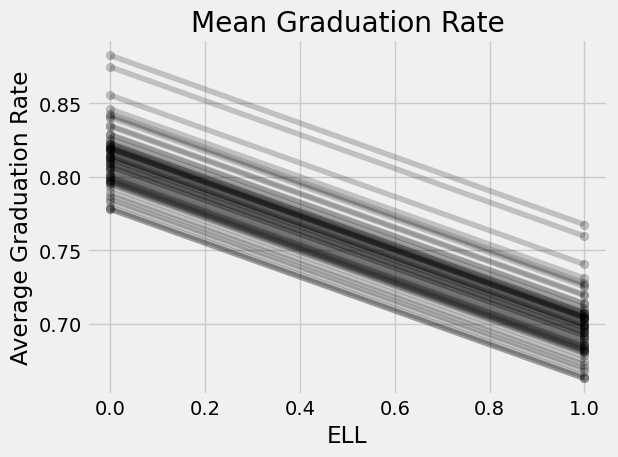

In [28]:
xvals = xr.DataArray([0, 1], dims="ELL", coords={"ELL": [0,1]})
post = varying_intercept_idata.posterior  # alias for readability
theta = (
    (post.a_county + post.b2 * xvals).mean(dim=("chain", "draw")).to_dataset(name="Average Graduation Rate")
)

_, ax = plt.subplots()
theta.plot.scatter(x="ELL", y="Average Graduation Rate", alpha=0.2, color="k", ax=ax)  # scatter
ax.plot(xvals, theta["Average Graduation Rate"].T, "k-", alpha=0.2)
# add lines too
ax.set_title("Mean Graduation Rate")
plt.tight_layout()
plt.savefig("images/ell_gradrate.png",dpi=300)

We can see that the effect of being an English Language Learner produces a lower average graduation rate ~70%-72% compared to ~ 83%. 

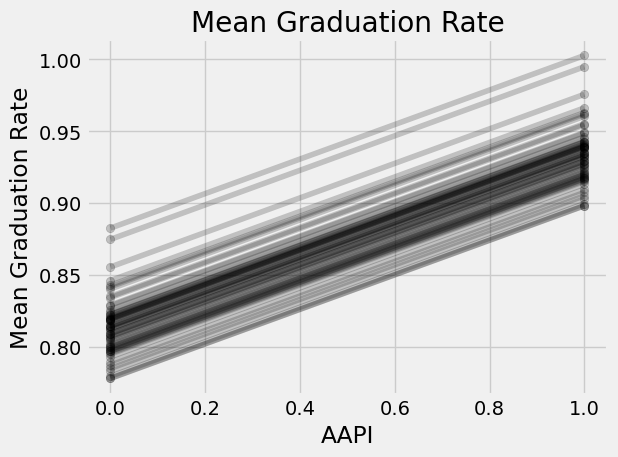

In [29]:
xvals = xr.DataArray([0, 1], dims="AAPI", coords={"AAPI": [0,1]})
post = varying_intercept_idata.posterior  # alias for readability
theta = (
    (post.a_county + post.b4 * xvals).mean(dim=("chain", "draw")).to_dataset(name="Mean Graduation Rate")
)

_, ax = plt.subplots()
theta.plot.scatter(x="AAPI", y="Mean Graduation Rate", alpha=0.2, color="k", ax=ax)  # scatter
ax.plot(xvals, theta["Mean Graduation Rate"].T, "k-", alpha=0.2)
# add lines too
ax.set_title("Mean Graduation Rate")
plt.tight_layout()
plt.savefig("images/aapi_gradrate.png",dpi=300);

We can see that the effect of being `Asian American or Native Hawaiian` produces a higher average graduation rate ~ 92-95% compared to ~ 83%. 

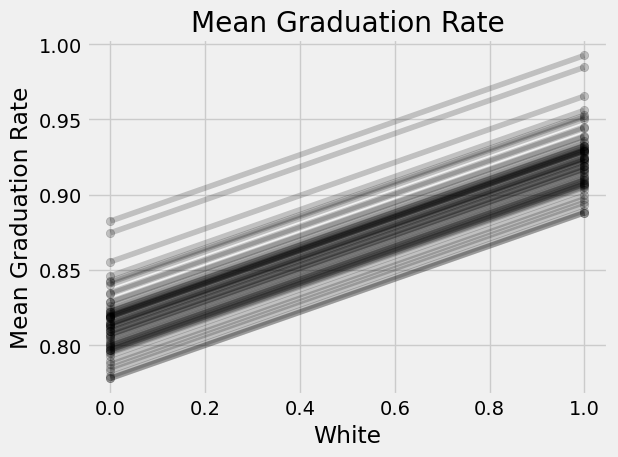

In [30]:
xvals = xr.DataArray([0, 1], dims="White", coords={"White": [0,1]})
post = varying_intercept_idata.posterior  # alias for readability
theta = (
    (post.a_county + post.b7 * xvals).mean(dim=("chain", "draw")).to_dataset(name="Mean Graduation Rate")
)

_, ax = plt.subplots()
theta.plot.scatter(x="White", y="Mean Graduation Rate", alpha=0.2, color="k", ax=ax)  # scatter
ax.plot(xvals, theta["Mean Graduation Rate"].T, "k-", alpha=0.2)
# add lines too
ax.set_title("Mean Graduation Rate")
plt.tight_layout()
plt.savefig("images/white_gradrate.png",dpi=300);

We can see that the effect of being `White` produces a higher average graduation rate ~ 92.5% compared to ~ 83%. 

### Posterior Predictive Checks

In [31]:
with varying_intercept:
    ppc = pm.sample_posterior_predictive(varying_intercept_idata,var_names=["alpha","y"])

Sampling: [a_county, alpha, y]


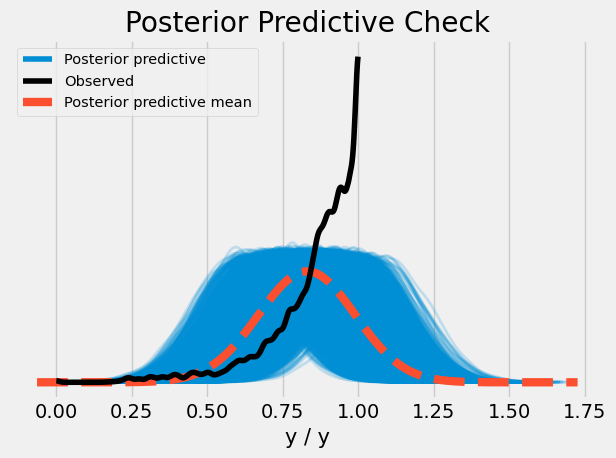

In [35]:
az.plot_ppc(ppc)
#plt.xlim(0,1)
plt.title("Posterior Predictive Check")
plt.tight_layout()
#plt.savefig("images/posterior_predictive_check.png")

### Saving GraphViz Model Outputs 

In [157]:
# storing our GraphViz objects to local variables 
pooled_gph = pm.model_to_graphviz(pooled_model)
unpooled_gph = pm.model_to_graphviz(unpooled_model)
var_ic_gph = pm.model_to_graphviz(varying_intercept)

# specifying the file paths for each model 
p_mdl_file_path = "images/pooledmodel"
up_mdl_file_path = "images/unpooledmodel"
vic_mdl_file_path = "images/varying_ic_model"

# rendering our models to their paths
pooled_gph.render(p_mdl_file_path,format="png")
unpooled_gph.render(up_mdl_file_path,format="png")
var_ic_gph.render(vic_mdl_file_path,format="png")

'images\\varying_ic_model.png'

In [245]:
var_ic_gph.attr = {'fontsize': '10','shape':'circle','size':'8,5'}
var_ic_gph.graph_attr = {'rankdir':'TR'}
var_ic_gph.node_attr = {'label':'predictors'}
var_ic_gph

AttributeError: 'Digraph' object has no attribute 'cluster'

### Predictions 

In [ ]:
with contextual_effect:
    pm.set_data({"county_idx": np.array([69, 31]), "floor_idx": np.array([1, 1])})
    stl_pred = pm.fast_sample_posterior_predictive(
        contextual_effect_idata.posterior, random_seed=RANDOM_SEED
    )
    az.from_pymc3_predictions(
        stl_pred, idata_orig=contextual_effect_idata, inplace=True, coords=prediction_coords
    )

In [124]:
county_lookup["Albany"],county_lookup["Queens"]

(0, 31)

In [142]:
with varying_intercept:
    pm.set_data({"county_idx": np.array([0,31]), "ells_idx": np.array([1,1])})
    stl_pred = pm.sample_posterior_predictive(varying_intercept_idata.posterior, random_seed=r_seed)

ValueError: The 'county_idx' variable already had 4680 coord values defined for its obs_id dimension. With the new values this dimension changes to length 2, so new coord values for the obs_id dimension are required.

In [207]:
var_ic_gph.node_attr

{'shape': 'circle'}